In [47]:
import os
import re
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:

base_dir = "/Users/christoffer/Downloads/GSE212576_RAW"
files = os.listdir(base_dir)

# --- helper to parse metadata from filename ---
# Example: GSM6537883_HIP_O_2_matrix.mtx.gz
rx = re.compile(r"^(GSM\d+)_(\w+)_([A-Z])_(\d+)")

def parse_meta(fname):
    m = rx.match(os.path.basename(fname))
    if not m:
        return {"GSM": None, "region": None, "condition": None, "rep": None}
    gsm, region, cond, rep = m.groups()
    return {
        "GSM": gsm,
        "region": region,        # HIP / CP
        "condition": cond,       # O / Y (Old/Young)
        "rep": rep               # replicate number
    }

# --- helper: read one triplet (matrix/features/barcodes) ---
def read_10x_triplet(barcodes_path, features_path, matrix_path):
    # barcodes
    barcodes = pd.read_csv(barcodes_path, sep="\t", header=None)[0].astype(str).values
    # features
    feats = pd.read_csv(features_path, sep="\t", header=None)
    feats.columns = ["gene_id", "gene_name", "feature_type"][:feats.shape[1]]
    if "feature_type" in feats.columns:
        feats = feats.loc[feats["feature_type"] == "Gene Expression"].copy()

    # matrix
    X = mmread(matrix_path)
    X = csr_matrix(X).T   # cells × genes

    var = pd.DataFrame(index=feats["gene_name"].astype(str).values)
    var["gene_id"] = feats["gene_id"].astype(str).values

    obs = pd.DataFrame(index=barcodes)

    ad = sc.AnnData(X=X, obs=obs, var=var)
    ad.var_names_make_unique()
    ad.layers["counts"] = ad.X.copy()
    return ad

# --- group files by sample stem ---
samples = {}
for f in files:
    stem = re.sub(r"_(barcodes|features|matrix).*", "", f)
    samples.setdefault(stem, []).append(f)

ad_list = []
for stem, flist in samples.items():
    # pick triplet
    bar = [os.path.join(base_dir, f) for f in flist if "barcodes" in f][0]
    feat = [os.path.join(base_dir, f) for f in flist if "features" in f][0]
    mtx = [os.path.join(base_dir, f) for f in flist if "matrix" in f][0]

    ad = read_10x_triplet(bar, feat, mtx)
    meta = parse_meta(os.path.basename(mtx))
    for k, v in meta.items():
        ad.obs[k] = v
    ad.obs["sample"] = stem
    ad_list.append(ad)

# --- concatenate all samples ---
adata = sc.concat(
    ad_list,
    join="outer",
    label="sample",
    keys=[a.obs["sample"].iloc[0] for a in ad_list],
    index_unique="-",
    fill_value=0
)

print(adata)
print(adata.obs[["sample","GSM","region","condition","rep"]].head())

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/

AnnData object with n_obs × n_vars = 109826 × 32285
    obs: 'GSM', 'region', 'condition', 'rep', 'sample'
    layers: 'counts'
                                                   sample         GSM region  \
AAACCCACAAAGGTTA-1-GSM6537883_HIP_O_2  GSM6537883_HIP_O_2  GSM6537883    HIP   
AAACCCACACACTTAG-1-GSM6537883_HIP_O_2  GSM6537883_HIP_O_2  GSM6537883    HIP   
AAACCCACACTGTCGG-1-GSM6537883_HIP_O_2  GSM6537883_HIP_O_2  GSM6537883    HIP   
AAACCCACATCCTTCG-1-GSM6537883_HIP_O_2  GSM6537883_HIP_O_2  GSM6537883    HIP   
AAACCCACATGTGACT-1-GSM6537883_HIP_O_2  GSM6537883_HIP_O_2  GSM6537883    HIP   

                                      condition rep  
AAACCCACAAAGGTTA-1-GSM6537883_HIP_O_2         O   2  
AAACCCACACACTTAG-1-GSM6537883_HIP_O_2         O   2  
AAACCCACACTGTCGG-1-GSM6537883_HIP_O_2         O   2  
AAACCCACATCCTTCG-1-GSM6537883_HIP_O_2         O   2  
AAACCCACATGTGACT-1-GSM6537883_HIP_O_2         O   2  


In [9]:
sample_dict = {
    "GSM6537880": {
        "sample": "HIP_Y_1",
        "region": "Hippocampus",
        "replicate": 1,
        "age_months": 3,
        "age_group": "Young"
    },
    "GSM6537881": {
        "sample": "HIP_Y_2",
        "region": "Hippocampus",
        "replicate": 2,
        "age_months": 3,
        "age_group": "Young"
    },
    "GSM6537882": {
        "sample": "HIP_O_1",
        "region": "Hippocampus",
        "replicate": 1,
        "age_months": 21,
        "age_group": "Old"
    },
    "GSM6537883": {
        "sample": "HIP_O_2",
        "region": "Hippocampus",
        "replicate": 2,
        "age_months": 21,
        "age_group": "Old"
    },
    "GSM6537884": {
        "sample": "CP_Y_1",
        "region": "Caudate putamen",
        "replicate": 1,
        "age_months": 3,
        "age_group": "Young"
    },
    "GSM6537885": {
        "sample": "CP_Y_2",
        "region": "Caudate putamen",
        "replicate": 2,
        "age_months": 3,
        "age_group": "Young"
    },
    "GSM6537886": {
        "sample": "CP_O_1",
        "region": "Caudate putamen",
        "replicate": 1,
        "age_months": 21,
        "age_group": "Old"
    },
    "GSM6537887": {
        "sample": "CP_O_2",
        "region": "Caudate putamen",
        "replicate": 2,
        "age_months": 21,
        "age_group": "Old"
    }
}

In [10]:
adata.obs["region"] = adata.obs["GSM"].map(lambda x: sample_dict[x]["region"])
adata.obs["replicate"] = adata.obs["GSM"].map(lambda x: sample_dict[x]["replicate"])
adata.obs["age_months"] = adata.obs["GSM"].map(lambda x: sample_dict[x]["age_months"])
adata.obs["age_group"] = adata.obs["GSM"].map(lambda x: sample_dict[x]["age_group"])
adata.obs["sample_label"] = adata.obs["GSM"].map(lambda x: sample_dict[x]["sample"])

In [15]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

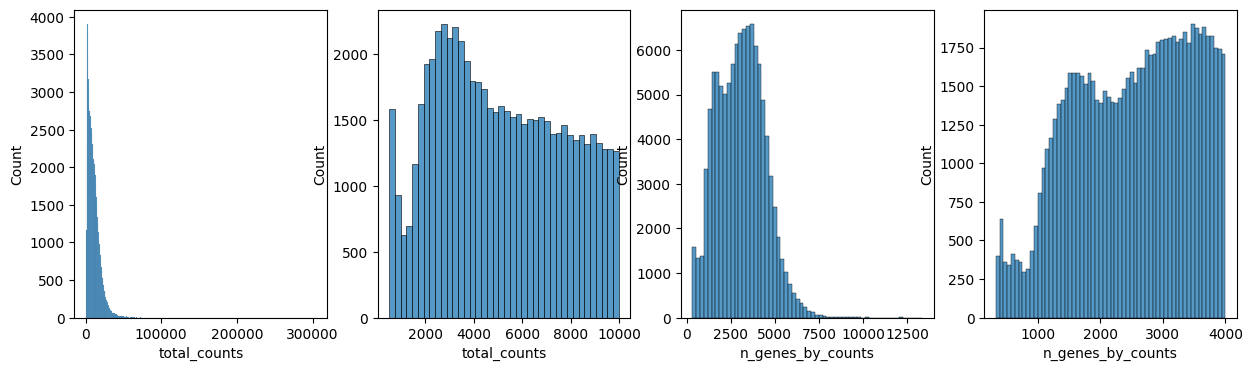

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)
plt.show()

In [25]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [26]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", directed=False, n_iterations=2)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


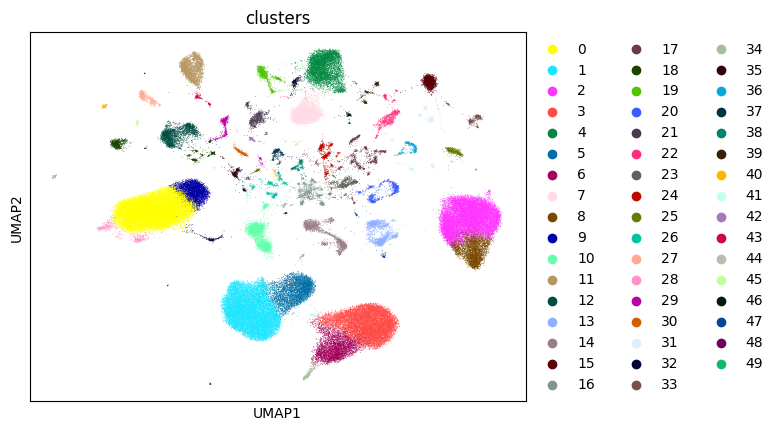

In [27]:
sc.pl.umap(adata, color = 'clusters')

In [29]:
adata

AnnData object with n_obs × n_vars = 109826 × 32285
    obs: 'GSM', 'region', 'condition', 'rep', 'sample', 'replicate', 'age_months', 'age_group', 'sample_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_49433/848545459.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="age_months", y="C4b_expr", inner="box", palette="muted")


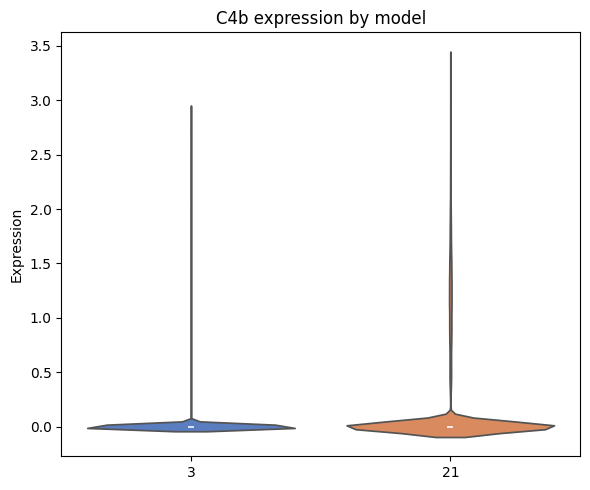

In [30]:
# pick gene
gene = "C4b"

# extract expression vector
if gene not in adata.var_names:
    raise ValueError(f"{gene} not found in adata.var_names")

c4b_expr = adata[:, gene].X
if hasattr(c4b_expr, "toarray"):  # handle sparse matrix
    c4b_expr = c4b_expr.toarray().ravel()
else:
    c4b_expr = np.asarray(c4b_expr).ravel()

# build dataframe
df = pd.DataFrame({
    "C4b_expr": c4b_expr,
    "age_months": adata.obs["age_months"].values
})

plt.figure(figsize=(6,5))
sns.violinplot(data=df, x="age_months", y="C4b_expr", inner="box", palette="muted")
plt.title("C4b expression by model")
plt.ylabel("Expression")
plt.xlabel("")
plt.tight_layout()
plt.show()

/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_49433/2806743800.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="age_months", y="C4b_expr", inner="box", palette="muted")


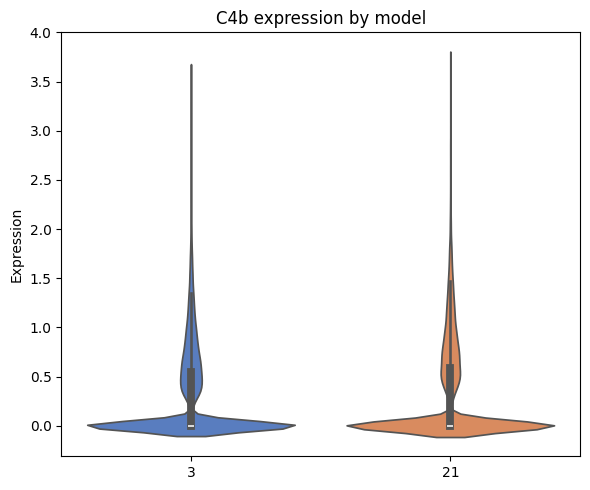

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# pick gene
gene = "Ldhb"

# extract expression vector
if gene not in adata.var_names:
    raise ValueError(f"{gene} not found in adata.var_names")

c4b_expr = adata[:, gene].X
if hasattr(c4b_expr, "toarray"):  # handle sparse matrix
    c4b_expr = c4b_expr.toarray().ravel()
else:
    c4b_expr = np.asarray(c4b_expr).ravel()

# build dataframe
df = pd.DataFrame({
    "C4b_expr": c4b_expr,
    "age_months": adata.obs["age_months"].values
})

plt.figure(figsize=(6,5))
sns.violinplot(data=df, x="age_months", y="C4b_expr", inner="box", palette="muted")
plt.title("C4b expression by model")
plt.ylabel("Expression")
plt.xlabel("")
plt.tight_layout()
plt.show()

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


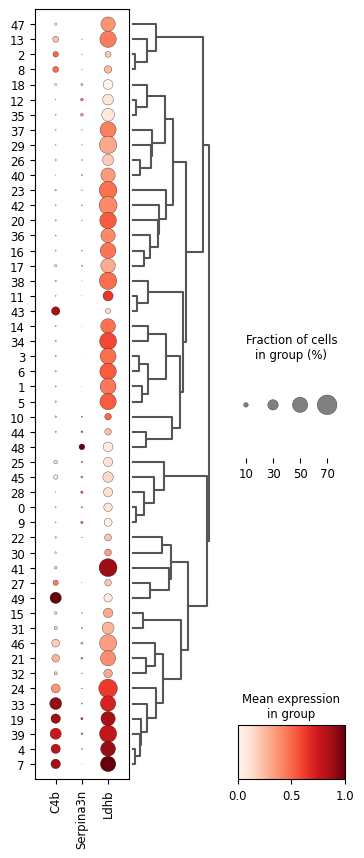

In [42]:
 sc.pl.dotplot(
        adata,
        var_names=['C4b', 'Serpina3n', 'Ldhb'],
        groupby="clusters",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=True,
        figsize=(4, 10)
    )

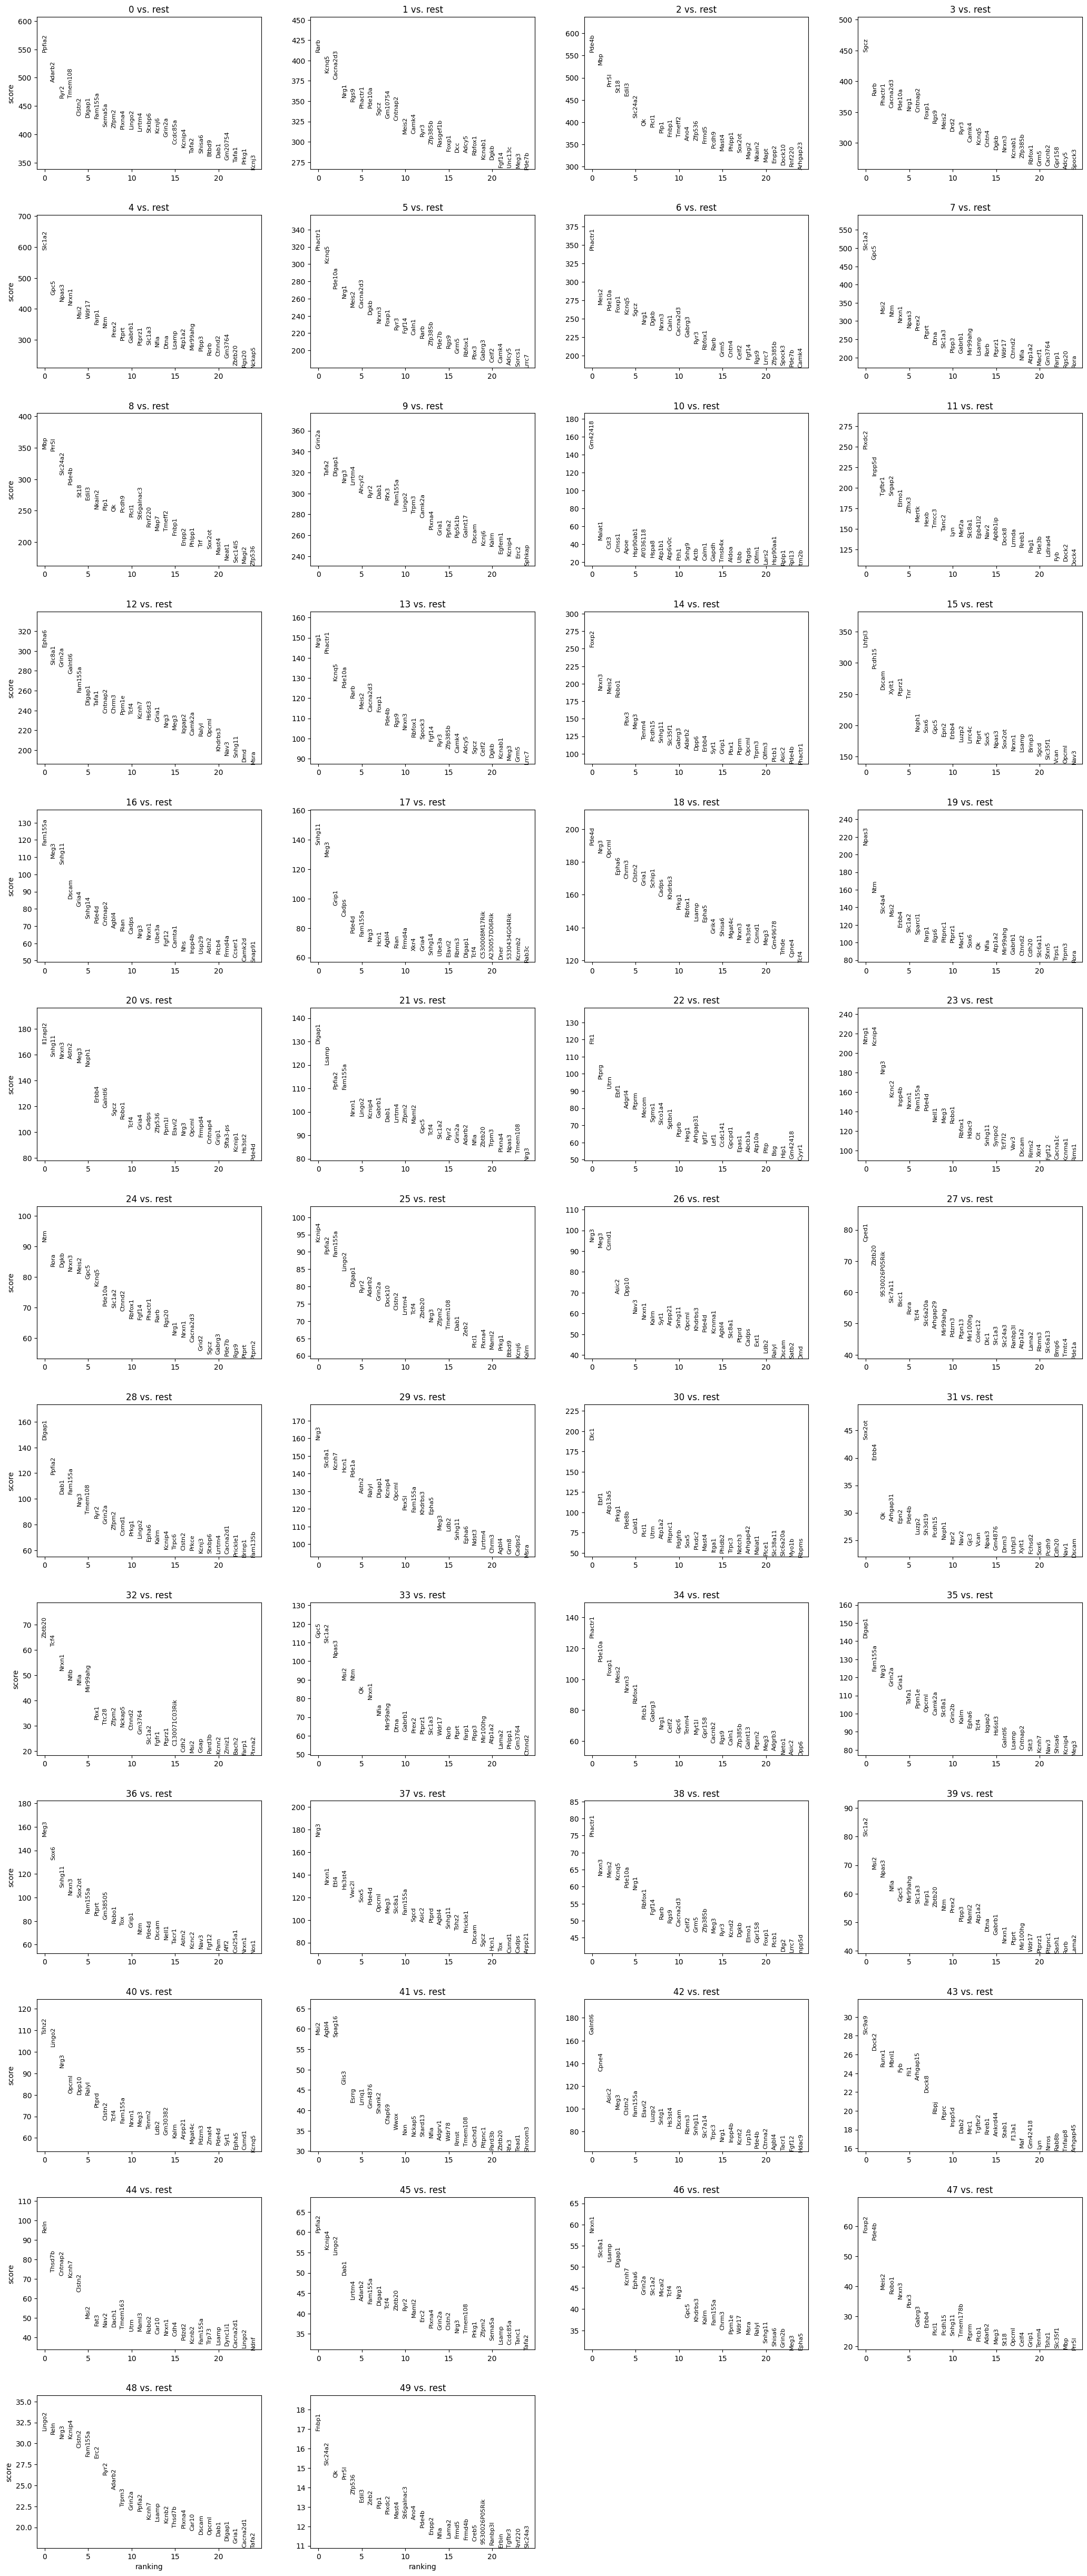

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Ppfia2,545.242188,3.550171,0.0,0.0
1,0,Adarb2,492.650116,4.609507,0.0,0.0
2,0,Ryr2,464.874908,3.191446,0.0,0.0
3,0,Tmem108,464.837097,4.331403,0.0,0.0
4,0,Clstn2,433.254639,3.905309,0.0,0.0


In [48]:

# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(adata, groupby="clusters", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(adata, group=None)
markers.head()

In [49]:
marker_genes = pd.DataFrame({
    group: adata.uns['rank_genes_groups']['names'][group][:5]
    for group in adata.uns['rank_genes_groups']['names'].dtype.names
})
marker_genes.head()
#marker_genes.to_csv('../data/broad_markers_leiden0-5.csv')

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,Ppfia2,Rarb,Pde4b,Sgcz,Slc1a2,Phactr1,Phactr1,Slc1a2,Mbp,Grin2a,...,Tshz2,Msi2,Galntl6,Slc9a9,Reln,Ppfia2,Nrxn1,Foxp2,Lingo2,Fnbp1
1,Adarb2,Kcnq5,Mbp,Rarb,Gpc5,Kcnq5,Meis2,Gpc5,Prr5l,Tafa2,...,Lingo2,Agbl4,Cpne4,Dock2,Thsd7b,Kcnip4,Slc8a1,Pde4b,Reln,Slc24a2
2,Ryr2,Cacna2d3,Prr5l,Phactr1,Npas3,Pde10a,Pde10a,Msi2,Slc24a2,Dlgap1,...,Nrg3,Spag16,Asic2,Runx1,Cntnap2,Lingo2,Lsamp,Meis2,Nrg3,Qk
3,Tmem108,Nrg1,St18,Cacna2d3,Nrxn1,Nrg1,Foxp1,Ntm,Pde4b,Nrg3,...,Opcml,Glis3,Meg3,Mbnl1,Kcnh7,Dab1,Dlgap1,Robo1,Kcnip4,Prr5l
4,Clstn2,Rgs9,Edil3,Pde10a,Msi2,Meis2,Kcnq5,Nrxn1,St18,Lrrtm4,...,Dpp10,Esrrg,Clstn2,Fyb,Clstn2,Lrrtm4,Kcnh7,Nrxn3,Clstn2,Zfp536


In [50]:
from mllmcelltype import annotate_clusters, setup_logging

In [51]:
from dotenv import load_dotenv
import os

load_dotenv()  # will read .env into environment
api_key = os.getenv("../OPENAI_API_KEY")

In [52]:
marker_genes = marker_genes.T

In [53]:
marker_genes = marker_genes.reset_index().rename(columns={'index':'cluster'})

In [54]:
marker_genes = marker_genes.set_index("cluster").T.to_dict("list")

In [55]:
import os

# Annotate clusters with a single model
annotations = annotate_clusters(
    marker_genes=marker_genes,  # DataFrame or dictionary of marker genes
    species='mouse',               # Organism species
    provider='openai',            # LLM provider
    model='gpt-4o-mini',               # Specific model
    tissue='brain'                #Tissue context (optional but recommended)
)

# Print annotations
for cluster, annotation in annotations.items():
    print(f"Cluster {cluster}: {annotation}")

2025-09-23 09:31:02 - llmcelltype - INFO - Logging initialized. Log file: /Users/christoffer/.llmcelltype/logs/llmcelltype_20250923_093102.log
2025-09-23 09:31:02 - llmcelltype - INFO - Starting annotation with provider: openai
2025-09-23 09:31:02 - llmcelltype - INFO - Found 50 clusters
2025-09-23 09:31:02 - llmcelltype - INFO - Creating prompt for 50 clusters
2025-09-23 09:31:02 - llmcelltype - INFO - Generated prompt with 2960 characters
2025-09-23 09:31:02 - llmcelltype - INFO - Processing request with openai using model gpt-4o-mini
2025-09-23 09:31:02 - llmcelltype - INFO - Starting OpenAI API request with model: gpt-4o-mini
2025-09-23 09:31:02 - llmcelltype - INFO - Using model: gpt-4o-mini
2025-09-23 09:31:02 - llmcelltype - INFO - Processing 1 chunks of input
2025-09-23 09:31:02 - llmcelltype - INFO - Processing chunk 1 of 1
2025-09-23 09:31:02 - llmcelltype - INFO - Sending API request...
2025-09-23 09:31:10 - llmcelltype - INFO - Got response with 50 lines
2025-09-23 09:31:10

Cluster 0: Neuron
Cluster 1: Neuron
Cluster 2: Oligodendrocyte
Cluster 3: Neuron
Cluster 4: Astrocyte
Cluster 5: Neuron
Cluster 6: Neuron
Cluster 7: Astrocyte
Cluster 8: Oligodendrocyte
Cluster 9: Neuron
Cluster 10: Astrocyte
Cluster 11: Microglia
Cluster 12: Neuron
Cluster 13: Neuron
Cluster 14: Neuron
Cluster 15: Neuron
Cluster 16: Neuron
Cluster 17: Neuron
Cluster 18: Neuron
Cluster 19: Astrocyte
Cluster 20: Astrocyte
Cluster 21: Neuron
Cluster 22: Endothelial
Cluster 23: Neuron
Cluster 24: Astrocyte
Cluster 25: Neuron
Cluster 26: Neuron
Cluster 27: Unknown
Cluster 28: Neuron
Cluster 29: Neuron
Cluster 30: Neuron
Cluster 31: Neural Stem Cell
Cluster 32: Neuron
Cluster 33: Astrocyte
Cluster 34: Neuron
Cluster 35: Neuron
Cluster 36: Neuron
Cluster 37: Neuron
Cluster 38: Neuron
Cluster 39: Astrocyte
Cluster 40: Neuron
Cluster 41: Unknown
Cluster 42: Oligodendrocyte
Cluster 43: Microglia
Cluster 44: Neuron
Cluster 45: Neuron
Cluster 46: Neuron
Cluster 47: Neuron
Cluster 48: Neuron
Clust

In [57]:
adata.obs['cellType'] = adata.obs.clusters.map(annotations)

In [58]:
import matplotlib.pyplot as plt

... storing 'cellType' as categorical


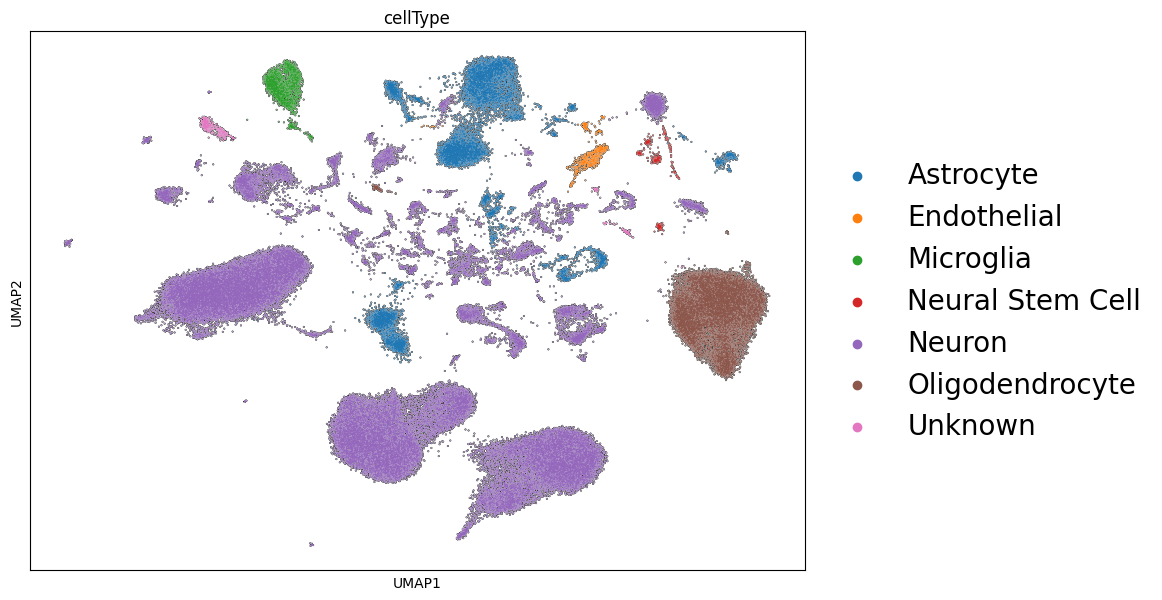

In [59]:
plt.rcdefaults()
with plt.rc_context({'figure.figsize': (10, 7)}):
    sc.pl.umap(adata,color = ("cellType"),s=3,add_outline=True,legend_fontsize=20,legend_fontoutline=2, ncols= 1, )

In [60]:
adata

AnnData object with n_obs × n_vars = 109826 × 32285
    obs: 'GSM', 'region', 'condition', 'rep', 'sample', 'replicate', 'age_months', 'age_group', 'sample_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters', 'cellType'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'dendrogram_clusters', 'rank_genes_groups', 'cellType_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

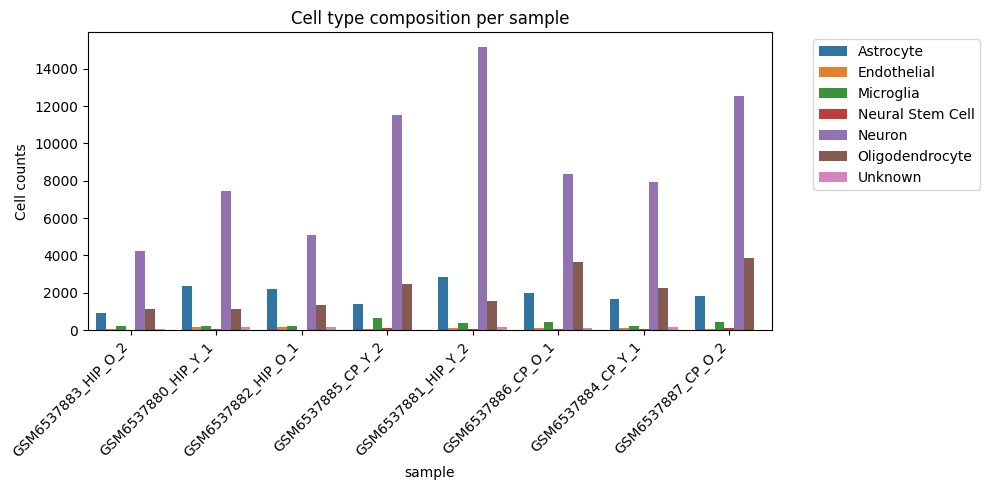

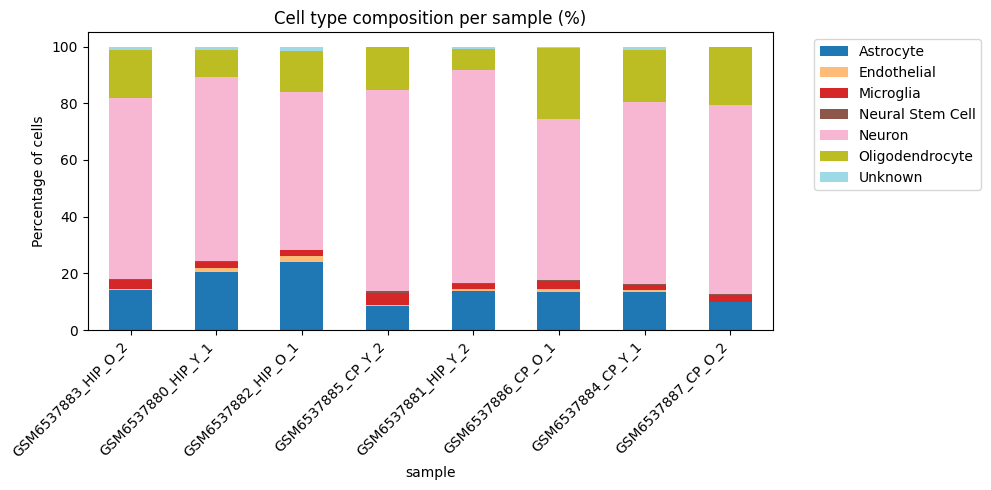

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build counts table: sample × cellType
ctab = (
    adata.obs.groupby(["sample", "cellType"])
    .size()
    .reset_index(name="count")
)

# Add percentages within each sample
ctab["percent"] = ctab.groupby("sample")["count"].transform(lambda x: 100 * x / x.sum())

# --- Plot raw counts ---
plt.figure(figsize=(10,5))
sns.barplot(data=ctab, x="sample", y="count", hue="cellType")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cell counts")
plt.title("Cell type composition per sample")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- Plot percentages (stacked bars) ---
pivot_pct = ctab.pivot(index="sample", columns="cellType", values="percent").fillna(0)

pivot_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    colormap="tab20"
)
plt.ylabel("Percentage of cells")
plt.title("Cell type composition per sample (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [68]:
adata

AnnData object with n_obs × n_vars = 109826 × 32285
    obs: 'GSM', 'region', 'condition', 'rep', 'sample', 'replicate', 'age_months', 'age_group', 'sample_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters', 'cellType'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'dendrogram_clusters', 'rank_genes_groups', 'cellType_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

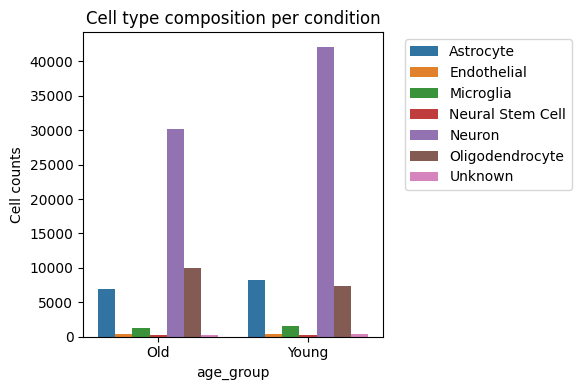

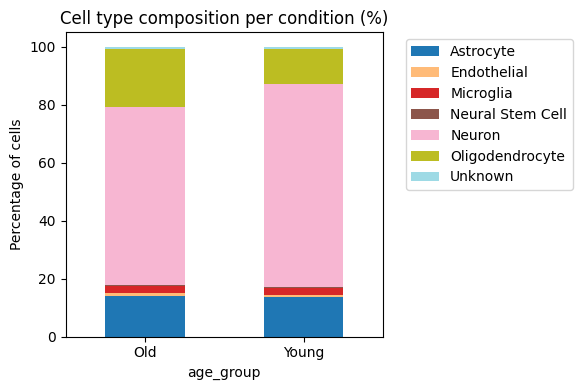

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- by CONDITION: counts + stacked percentages ---
ctab_cond = (
    adata.obs.groupby(["age_group", "cellType"])
    .size()
    .reset_index(name="count")
)
ctab_cond["percent"] = ctab_cond.groupby("age_group")["count"].transform(lambda x: 100 * x / x.sum())

# Raw counts per condition
plt.figure(figsize=(6,4))
sns.barplot(data=ctab_cond, x="age_group", y="count", hue="cellType")
plt.ylabel("Cell counts")
plt.title("Cell type composition per condition")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Stacked % per condition
pivot_pct_cond = ctab_cond.pivot(index="age_group", columns="cellType", values="percent").fillna(0)
pivot_pct_cond.plot(kind="bar", stacked=True, figsize=(6,4), colormap="tab20")
plt.ylabel("Percentage of cells")
plt.title("Cell type composition per condition (%)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

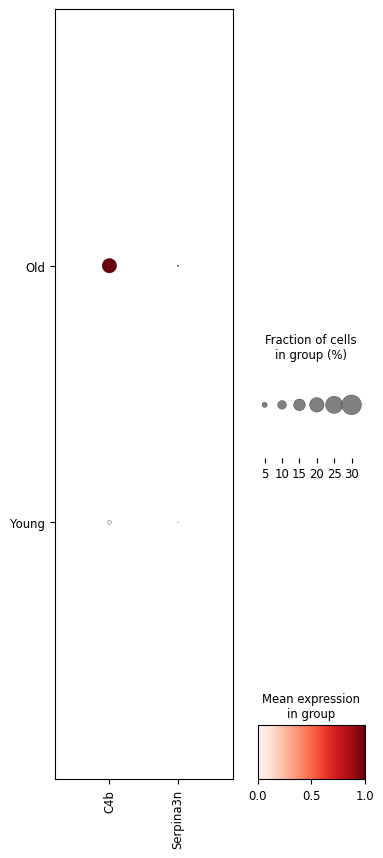

In [75]:
 sc.pl.dotplot(
        adata[adata.obs.cellType == 'Oligodendrocyte'],
        var_names=['C4b','Serpina3n'],
        groupby="age_group",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=True,
        figsize=(4, 10)
    )

# correlation

In [76]:
import numpy as np
import pandas as pd

# Subset to DA-oligos only
# Extract C4b expression vector
c4b_idx = adata.var_names.get_loc("C4b")
c4b_expr = adata.X[:, c4b_idx].toarray().ravel() if hasattr(adata.X, "toarray") else adata.X[:, c4b_idx].ravel()

# Convert X to dense DataFrame
X = adata.to_df()

# Compute correlations with C4b
cors = X.corrwith(pd.Series(c4b_expr, index=X.index))

# Compute mean expression per gene
means = X.mean()

# Build combined DataFrame
results = pd.DataFrame({
    "gene": cors.index,
    "corr_with_C4b": cors.values,
    "mean_expression": means.values
})

# Sort by correlation
results = results.sort_values("corr_with_C4b", ascending=False).reset_index(drop=True)

# Top 30
top_genes = results.head(50)


In [77]:
top_genes = top_genes[top_genes.corr_with_C4b < 1]

In [ ]:
import matplotlib.pyplot as plt

def dotplot_corr_expr(results, top_n=30):
    """
    Dotplot of genes ranked by correlation with C4b.
    Dot size = mean expression, Dot color = correlation with C4b.
    """
    df = results.sort_values("corr_with_C4b", ascending=False).head(top_n)

    plt.figure(figsize=(8, 0.4*top_n))
    sc = plt.scatter(
        x=df["corr_with_C4b"],
        y=df["gene"],
        s=df["mean_expression"]*100,   # scale size by mean expression
        c=df["corr_with_C4b"],
        cmap="Reds",
        alpha=0.8,
        edgecolor="k"
    )

    plt.xlabel("Correlation with C4b")
    plt.ylabel("Gene")
    plt.colorbar(sc, label="Correlation")
    plt.title("Top C4b co-expressed genes\n(size = mean expression)")

    # --- add size legend, positioned outside ---
    sizes = [df["mean_expression"].min(), df["mean_expression"].median(), df["mean_expression"].max()]
    labels = [f"{s:.2f}" for s in sizes]
    handles = [plt.scatter([], [], s=s*100, color="gray", alpha=0.6, edgecolor="k") for s in sizes]

    plt.legend(
        handles, labels, title="Mean expression",
        bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True
    )

    plt.tight_layout()
    plt.show()

# usage
dotplot_corr_expr(top_genes, top_n=30)

# Regression-based approach

In [ ]:
from sklearn.linear_model import LassoCV

X = adata.to_df().drop(columns=["C4b"])
y = adata.to_df()["C4b"]

lasso = LassoCV(cv=5).fit(X, y)
coefs = pd.Series(lasso.coef_, index=X.columns)
coefs = coefs[coefs != 0].sort_values(ascending=False)
print(coefs.head(20))

# Mutual information (nonlinear associations)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

X = adata.to_df().drop(columns=["C4b"])
y = adata.to_df()["C4b"]

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores.head(20))

# Cell-level co-expression probability

In [ ]:
X = adata.to_df()
c4b_pos = X["C4b"] > 0

coexpr_fraction = (X.loc[c4b_pos] > 0).mean()
coexpr_fraction.sort_values(ascending=False).head(50)

In [ ]:
coexpr_fraction 